In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

In [4]:
epochs = 10
batch_size = 512

device = ("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] # 총 10개의 클래스

In [5]:
device

'cuda'

In [6]:
torch.__version__

'2.1.0.post300'

In [8]:
transform = transforms.Compose(transforms=[transforms.Resize(size=(227, 227)),
                                           transforms.ToTensor()])

training_data = datasets.FashionMNIST(root="data", train=True, transform=transform, download=True)
validation_data = datasets.FashionMNIST(root="data", train=False, transform=transform, download=True)

In [12]:
training_loader = DataLoader(dataset=training_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(dataset=validation_data, batch_size=64, shuffle=True)

In [23]:
def matplotlib_imshow(image):
    image = image.mean(dim=0)
    image = image / 2 + 0.5
    np_image = image.numpy()
    plt.imshow(X=np_image, cmap="Greys")

In [21]:
dataiter = iter(training_loader)
images, labels = next(dataiter)

In [22]:
image_grid = torchvision.utils.make_grid(tensor=images[0])      # make_grid() : make the grid on the image

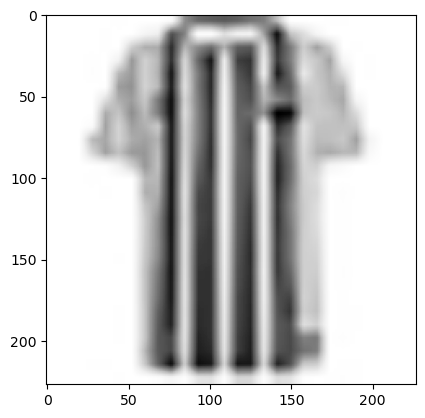

In [24]:
matplotlib_imshow(image=image_grid)

In [25]:
print(class_names[labels[0]])

T-shirt/top


In [41]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.Conv1_layer = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=96, kernel_size=(11, 11), stride=4, padding=0),
                                         nn.ReLU(),
                                         nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=0)
                                         )
        self.Conv2_layer = nn.Sequential(nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(5,5), stride=1, padding=2),
                                         nn.ReLU(),
                                         nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=0)
                                         )
        self.Conv3_layer = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3, 3), stride=1, padding=1),
                                         nn.ReLU(),
                                                            # NO MAXPOOLING in the 3rd layer
                                         )
        self.Conv4_layer = nn.Sequential(nn.Conv2d(in_channels=384, out_channels=384, kernel_size=(3, 3), stride=1, padding=1),
                                         nn.ReLU()
                                                            # NO MAXPOOLING in the 4th layer
                                         )
        self.Conv5_layer = nn.Sequential(nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3, 3), stride=1, padding=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=0)
                                         )
        self.FC6_layer = nn.Sequential(nn.Linear(in_features=256 * 6 * 6, out_features=4096),
                                       nn.ReLU()
                                       )
        
        
        self.FC7_layer = nn.Sequential(nn.Linear(in_features=4096, out_features=4096),
                                       nn.ReLU()
                                       )

        self.FC8_layer = nn.Sequential(nn.Linear(4096, 10),
                                       nn.LogSoftmax(dim=1)
                                       )

    
    def forward(self, input_image):
        output_Conv1 = self.Conv1_layer(input_image)
        output_Conv2 = self.Conv2_layer(output_Conv1)
        output_Conv3 = self.Conv3_layer(output_Conv2)
        output_Conv4 = self.Conv4_layer(output_Conv3)
        output_Conv5 = self.Conv5_layer(output_Conv4)
        output_Conv5 = output_Conv5.view(output_Conv5.size(0), -1)
        
        output_FC6 = self.FC6_layer(output_Conv5)
        output_FC6 = F.dropout(input=output_FC6, p=0.5)         # Let's move these dropout to inside of the __init__

        output_FC7 = self.FC7_layer(output_FC6)
        output_FC7 = F.dropout(input=output_FC7, p=0.5)

        output_FC8 = self.FC8_layer(output_FC7)
        # output_FC8 = F.log_softmax(input=output_FC8, dim=1)
        
        return output_FC8

In [47]:
model = AlexNet().to(device=device)
criterion = F.nll_loss
optimizer = optim.Adam(params=model.parameters())

In [48]:
from torchsummary import summary

summary(model=model, input_size=(1, 227, 227), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [512, 96, 55, 55]          11,712
              ReLU-2          [512, 96, 55, 55]               0
         MaxPool2d-3          [512, 96, 27, 27]               0
            Conv2d-4         [512, 256, 27, 27]         614,656
              ReLU-5         [512, 256, 27, 27]               0
         MaxPool2d-6         [512, 256, 13, 13]               0
            Conv2d-7         [512, 384, 13, 13]         885,120
              ReLU-8         [512, 384, 13, 13]               0
            Conv2d-9         [512, 384, 13, 13]       1,327,488
             ReLU-10         [512, 384, 13, 13]               0
           Conv2d-11         [512, 256, 13, 13]         884,992
             ReLU-12         [512, 256, 13, 13]               0
        MaxPool2d-13           [512, 256, 6, 6]               0
           Linear-14                [51

In [49]:
def train(model, device, train_loader, optimizer, epoch):

    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(input=output, target=target)
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 30 == 0:
            print(f"train epoch : {epoch} [{batch_idx * len(data)} / {len(train_loader)}] ({100.0 * batch_idx / len(training_loader):.0f}) \t loss : {loss.item():.6f}")

In [50]:
def test(model, device, test_loader):
    
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(input=output, target=target)
            predict = output.max(1, keepdim=True)[1]
            correct += predict.eq(target.view_as(predict)).sum().item()

        test_loss /= len(test_loader.dataset)

        print(f"\ntest set : average loss : {test_loss:.4f}, accuracy : {correct} / {len(test_loader.dataset)}\t ({100.0 * correct / len(test_loader.dataset):.0f})\n")
        print("=" * 50)

In [51]:
for epoch in range(1, 2):
    train(model=model, device=device, train_loader=training_loader, optimizer=optimizer, epoch=epoch)
    test(model=model, device=device, test_loader=validation_loader)

train epoch : 1 [1856 / 938] (3) 	 loss : 1.185129
train epoch : 1 [3776 / 938] (6) 	 loss : 0.868248
train epoch : 1 [5696 / 938] (9) 	 loss : 0.858751
train epoch : 1 [7616 / 938] (13) 	 loss : 0.646044
train epoch : 1 [9536 / 938] (16) 	 loss : 0.505016
train epoch : 1 [11456 / 938] (19) 	 loss : 0.836795
train epoch : 1 [13376 / 938] (22) 	 loss : 0.494011
train epoch : 1 [15296 / 938] (25) 	 loss : 0.616802
train epoch : 1 [17216 / 938] (29) 	 loss : 0.461690
train epoch : 1 [19136 / 938] (32) 	 loss : 0.516425
train epoch : 1 [21056 / 938] (35) 	 loss : 0.505633
train epoch : 1 [22976 / 938] (38) 	 loss : 0.671179
train epoch : 1 [24896 / 938] (41) 	 loss : 0.472372
train epoch : 1 [26816 / 938] (45) 	 loss : 0.698766
train epoch : 1 [28736 / 938] (48) 	 loss : 0.435200
train epoch : 1 [30656 / 938] (51) 	 loss : 0.349524
train epoch : 1 [32576 / 938] (54) 	 loss : 0.504364
train epoch : 1 [34496 / 938] (57) 	 loss : 0.329493
train epoch : 1 [36416 / 938] (61) 	 loss : 0.382640
t